In [1]:
from zipfile import ZipFile
import os
import xml.sax, xml.sax.handler
import numpy as np
import numpy.ma as ma
import pandas as pd
import pickle
import xarray as xr
from shapely.geometry import Polygon, LineString
import utm
from pyproj import Proj
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

mpl.rcParams['figure.dpi']= 300
fs = 7
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
plt.rcParams['font.size'] = fs
plt.rcParams['figure.facecolor'] = 'white'

<ipython-input-1-79256745986e>:23: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


In [2]:
def get_dfinfo(dfno):
    with open('dunefields/df%d_verts.pkl'%dfno, 'rb') as f:
        vertups = pickle.load(f) # lon,lat

    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])
    vertups[:,0] += 180
    
    return Polygon(vertups),Polygon(XY.T).area,Polygon(vertups).centroid.coords.xy[1][0],Polygon(vertups).centroid.coords.xy[0][0]

def dfmean(q):
    q_dfmeandims = np.asarray(np.shape(q))
    q_dfmeandims[-1] = Ndunefields
    q_dfmean = np.empty(q_dfmeandims)
    for i in range(Ndunefields):
        q_dfmean[...,i] = np.sum(np.squeeze(q[...,np.argwhere(Dunefield_num==i)])*np.squeeze(Dunefield_frac[np.argwhere(Dunefield_num==i)])[tuple([np.newaxis]*(len(np.asarray(np.shape(q)))-1))],axis=-1)/np.sum(Dunefield_frac[np.argwhere(Dunefield_num==i)])
    return q_dfmean

def cVeg_from_files(scenario,year):
    path = directory + 'ec-earth3-veg-mon-cveg-scenario-ends/' + scenario + '/'
    dirs = []
    for file in os.listdir(path):
        if file.startswith('.') or file.startswith('wget'):
            continue
        else:
            if int(file.split('_')[-1][:4])==year:
                if file.startswith('cVeg'):
                    dirs.append(file)
    dirs = sorted(dirs)

    flag = []
    temp = xr.open_dataset(path+dirs[0])
    t    = np.asarray(temp.time).astype('float')*1e-9
    cV   = np.empty((len(dirs),len(t),len(Dunefield_tileinds)))
    for k in range(len(dirs)):
        try:
            cVeg = np.asarray(xr.open_dataset(path+dirs[k]).cVeg)
        except:
            cVeg = np.ones(np.shape(xr.open_dataset(path+dirs[k]).cVeg))*np.nan
            flag.append('cVeg %d'%k)
        
        cV[k] = cVeg[:,Dunefield_tileinds[:,1],Dunefield_tileinds[:,0]]

        print('%d of %d runs loaded'%((k+1),len(dirs)),end='\r')
    
    return cV,t,flag

# Extended Figure H

In [3]:
directory = '/media/andle/Samsung_T5/cmip6/'
with open(directory + 'ec-earth3-firstdim-info.pkl', 'rb') as f:
    Dunefield_num,Dunefield_tileinds,Dunefield_latlon,Dunefield_frac = pickle.load(f)
    
Ndunefields = len(np.unique(Dunefield_num))
scenarios = ['historical','ssp585']
years = [range(2010,2014+1),range(2096,2100+1)]
Nensmembers = [6,6]

s2yr = (60*60*24*365)**-1
s2hr = (60*60)**-1

dfs = [None for i in range(Ndunefields)]
df_avlat = np.empty(Ndunefields)
df_avlon = np.empty(Ndunefields)
df_area  = np.empty(Ndunefields)
for i in range(Ndunefields):
    dfs[i],df_area[i],df_avlat[i],df_avlon[i] = get_dfinfo(i)
    
df_name = ['Namib Sand Sea',
           'Grand Erg Occidental',
           'Grand Erg Oriental',
           'West Erg Issaouane',
           'East Erg Issaouane',
           'Idehan Ubari',
           'Idehan Murzuk',
           'Central Great Sand Sea',
           'Dakhla Farafra',
           'Sinai Negev Erg',
           'An Nafud \& Ad Dahna',
           'Rub Al Khali',
           'Ramlat Al Sabatayn',
           'Wahiba Sands',
           'West Registan Desert',
           'Kharan Desert',
           'Karakum Desert',
           'Thar Desert',
           'Rig-e Jenn',
           'Rig-e Yalan',
           'East Registan Desert',
           'Southwest Takla Makan',
           'Northwest Takla Makan',
           'Central Takla Makan',
           'East Takla Makan',
           'Kumtag Desert',
           'Badain Jaran Desert',
           'Tengger Desert',
           'Ulan Buh Desert',
           'Hobp Desert',
           'Munga-Thirri',
           'Yamma Yamma',
           'Gran Desierto',
           'Ergs Iguidi \& Chech',
           'Aoukar',
           'El Djouf',
           'Azefal, Akchar \& Agneitir',
           'Trarza Reion Desert',
           'Skeleton Coast Dune Field',
           'Cunene Namib Desert',
           'Baia dos Tigres Namib Desert',
           'White Sands Dune Field',
           'Algodones',
           'Fachi Bilma',
           'Zaltan Sand Sea']

In [4]:
for i in range(len(scenarios)):
    for j in range(len(years[i])):
        cV,t,flag = cVeg_from_files(scenarios[i],years[i][j])
        with open(directory + 'ec-earth3-veg-mon-cveg-scenario-ends/processed/' + scenarios[i] + '-' + str(years[i][j]) + '.pkl', 'wb') as f:
            pickle.dump((cV,t,flag),f)
        print('%d of %d years loaded'%((j+1),len(years[i])),end='\r')

In [5]:
scenario_dfavg_cV = np.empty((len(scenarios),len(dfs)))
scenario_dfstd_cV = np.empty((len(scenarios),len(dfs)))

for i in range(len(scenarios)):
    for j in range(len(years[i])):
        cV,t,flag = cVeg_from_files(scenarios[i],years[i][j])
        with open(directory + 'ec-earth3-veg-mon-cveg-scenario-ends/processed/' + scenarios[i] + '-' + str(years[i][j]) + '.pkl', 'rb') as f:
            cV,t,flag = pickle.load(f)
        if j==0:
            stack = dfmean(cV).reshape(-1, dfmean(cV).shape[-1])
        else:
            stack = np.concatenate((stack, dfmean(cV).reshape(-1, dfmean(cV).shape[-1])), axis=0)
    scenario_dfavg_cV[i] = np.mean(stack,axis=0)
    scenario_dfstd_cV[i] = np.std(stack,axis=0)

In [6]:
field = xr.open_dataset(directory + 'ec-earth3-veg-mon-cveg-scenario-ends/historical/' + 'cVeg_Lmon_EC-Earth3-Veg_historical_r2i1p1f1_gr_201401-201412.nc')

cVeg = np.asarray(field.cVeg)

landmask  = np.asarray(xr.open_dataset(directory + 'tslsi_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-18501231.nc').tslsi)[0]
landmask  = landmask/landmask*1
oceanmask = np.copy(landmask)
oceanmask[np.isnan(oceanmask)] = 2

temp = np.ndarray.flatten(np.mean(np.asarray(field.cVeg),axis=0)*landmask)
temp = temp[~np.isnan(temp)]

In [7]:
delta = scenario_dfavg_cV[1]-scenario_dfavg_cV[0]
print(len(delta[delta==0]))
print(len(delta[delta>0]))
print(len(delta[delta<0]))

28
14
3


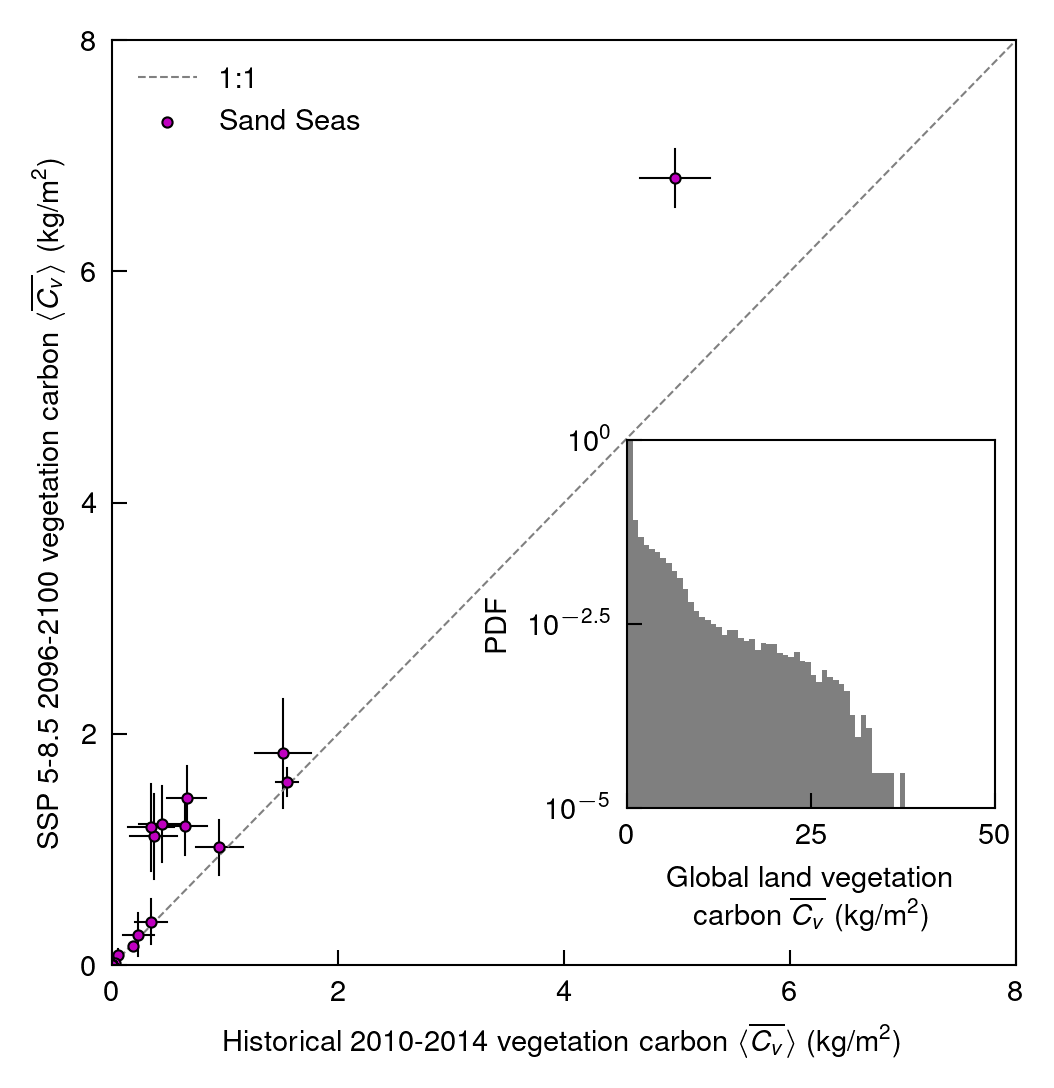

In [8]:
S = 6
lw = 0.5
mlw = 0.5

fig = plt.gcf()

ax0 = fig.add_axes([0.12,0.1,0.86,0.88])

plt.scatter(scenario_dfavg_cV[0],scenario_dfavg_cV[1],facecolor='m',edgecolor='k',s=S,lw=lw,label='Sand Seas')
plt.plot([scenario_dfavg_cV[0]+scenario_dfstd_cV[0],
          scenario_dfavg_cV[0]-scenario_dfstd_cV[0]],
          [scenario_dfavg_cV[1],
           scenario_dfavg_cV[1]],c='k',lw=lw,zorder=-1)
plt.plot([scenario_dfavg_cV[0],
          scenario_dfavg_cV[0]],
          [scenario_dfavg_cV[1]+scenario_dfstd_cV[1],
           scenario_dfavg_cV[1]-scenario_dfstd_cV[1]],c='k',lw=lw,zorder=-1)
plt.plot([0,10],[0,10],'--',c='grey',lw=lw,label='1:1',zorder=-1)
plt.legend(frameon=False)
plt.xlim(0,8)
plt.ylim(0,8)
plt.xlabel('Historical 2010-2014 vegetation carbon $\\langle\\overline{C_v}\\rangle$ (kg/m$^2$)')
plt.ylabel('SSP 5-8.5 2096-2100 vegetation carbon $\\langle\\overline{C_v}\\rangle$ (kg/m$^2$)')
ax0.set_xticks([0,2,4,6,8])
ax0.set_xticklabels(['0','2','4','6','8'])
ax0.set_yticks([0,2,4,6,8])
ax0.set_yticklabels(['0','2','4','6','8'])

ax01 = fig.add_axes([0.61,0.25,0.35,0.35])

plt.hist(temp,bins=50,log=True,density=True,color='k',alpha=0.5)

plt.ylim(1e-5,1e+0)
plt.xlim(0,50)
plt.xlabel('Global land vegetation\ncarbon $\\overline{C_v}$ (kg/m$^2$)')
plt.ylabel('PDF')

ax01.set_xticks([0,25,50])
ax01.set_xticklabels(['0','25','50'])
ax01.set_yticks([1e-5,10**-2.5,1e+0])
ax01.set_yticklabels(['$10^{-5}$','$10^{-2.5}$','$10^{0}$'])

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax01.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax01.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(89/25.4,89/25.4, forward=True)
plt.savefig('figures/edfigH.pdf',dpi=600)
plt.savefig('figures/edfigH.png',dpi=600)

# Extended Figure I

In [9]:
def get_qe_params(qe_counts_scenario_ends,qe_bins_scenario_ends,scale,density,cdf,func,power=np.nan,xmin=0,xmax=np.inf):
    if func=='exp':
        params = np.empty((len(scenarios),len(Dunefield_num),2))
    else:
        params = np.empty((len(scenarios),len(Dunefield_num)))
    
    for i in range(len(scenarios)):
        for j in range(len(Dunefield_num)):
            if density:
                if cdf:
                    tempy = 1-np.cumsum(qe_counts_scenario_ends[i,j]*np.diff(qe_bins_scenario_ends[i,j]))
                else:
                    tempy = qe_counts_scenario_ends[i,j]
            else:
                tempy = qe_counts_scenario_ends[i,j]/np.sum(qe_counts_scenario_ends[i,j])
            if scale=='lin':
                tempx = qe_bins_scenario_ends[i,j][1:]-np.diff(qe_bins_scenario_ends[i,j])[0]/2
            elif scale=='log':
                tempx = 10**(np.log10(qe_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qe_bins_scenario_ends[i,j]))[0]/2)    

            if func=='exp':
                Nbins = len(tempx)+1
                tempp = np.polyfit(tempx[-int(Nbins*3/4):-1],np.log(tempy[-int(Nbins*3/4):-1]),deg=1)
                params[i,j] = [-1/tempp[0],np.exp(tempp[1])]
            elif func=='hund':
                ftemp = interp1d(tempy, tempx)
                params[i,j] = ftemp(1e-2)
            elif func=='strexp':
                params[i,j] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)]**power)[:-1,np.newaxis], -np.log(tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]),rcond=None)[0]**(-1/power)
            elif func=='pwrlaw':
                params[i,j] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)])[:-1,np.newaxis], tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]**(-1/power),rcond=None)[0]**-1

    return params

def get_qe_globparams(qe_counts_globscenario_ends,qe_bins_globscenario_ends,scale,density,cdf,func,power=np.nan,xmin=0,xmax=np.inf):
    if func=='exp':
        params = np.empty((len(scenarios),2))
    else:
        params = np.empty((len(scenarios)))
    
    for i in range(len(scenarios)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qe_counts_globscenario_ends[i]*np.diff(qe_bins_globscenario_ends[i]))
            else:
                tempy = qe_counts_globscenario_ends[i]
        else:
            tempy = qe_counts_globscenario_ends[i]/np.sum(qe_counts_globscenario_ends[i])
        if scale=='lin':
            tempx = qe_bins_globscenario_ends[i][1:]-np.diff(qe_bins_globscenario_ends[i])[0]/2
        elif scale=='log':
            tempx = 10**(np.log10(qe_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qe_bins_globscenario_ends[i]))[0]/2)    

        if func=='exp':
            Nbins = len(tempx)+1
            tempp = np.polyfit(tempx[-int(Nbins*3/4):-1],np.log(tempy[-int(Nbins*3/4):-1]),deg=1)
            params[i] = [-1/tempp[0],np.exp(tempp[1])]
        elif func=='hund':
            ftemp = interp1d(tempy, tempx)
            params[i] = ftemp(1e-2)
        elif func=='strexp':
            params[i] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)]**power)[:-1,np.newaxis], -np.log(tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]),rcond=None)[0]**(-1/power)
        elif func=='pwrlaw':
            params[i] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)])[:-1,np.newaxis], tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]**(-1/power),rcond=None)[0]**-1

    return params

cdf = True

qetfunc  = 'hund'
qetpower = np.nan
qetxmin = 0
qetxmax = np.inf

qemfunc  = 'hund'
qempower = np.nan
qemxmin = 0
qemxmax = np.inf

Nbins = 60
Nyears = 10
Nmonths = 12
globbinfactor = 10
mscale = 'lin'
tscale = 'lin'
density = True

In [10]:
scenarios = ['historical','ssp126','ssp245','ssp370','ssp585']

with open(directory+'q_info_scenario_ends.pkl', 'rb') as f:
    (mean_summq_scenario_ends,
     std_summq_scenario_ends,
     mean_msumqm_scenario_ends,
     std_msumqm_scenario_ends,
     mean_fd_scenario_ends,
     std_fd_scenario_ends,
     mean_msumqa_scenario_ends,
     qem_counts_scenario_ends,
     qem_bins_scenario_ends,
     qet_counts_scenario_ends,
     qet_bins_scenario_ends,
     qem_counts_globscenario_ends,
     qem_bins_globscenario_ends,
     qet_counts_globscenario_ends,
     qet_bins_globscenario_ends,                 
     mean_maxtrimonth_mean_summq_props_scenario_ends,
     std_maxtrimonth_mean_summq_props_scenario_ends) = pickle.load(f)

qet_params_scenario_ends = get_qe_params(qet_counts_scenario_ends,qet_bins_scenario_ends,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)
qet_params_globscenario_ends = get_qe_globparams(qet_counts_globscenario_ends,qet_bins_globscenario_ends,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)

qem_params_scenario_ends = get_qe_params(qem_counts_scenario_ends,qem_bins_scenario_ends,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)
qem_params_globscenario_ends = get_qe_globparams(qem_counts_globscenario_ends,qem_bins_globscenario_ends,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)

mean_summq_scenario_ends_dfmean = dfmean(mean_summq_scenario_ends)
mean_msumqm_scenario_ends_dfmean = dfmean(mean_msumqm_scenario_ends)
mean_fd_scenario_ends_dfmean = dfmean(mean_fd_scenario_ends)
mean_msumqa_scenario_ends_dfmean = dfmean(mean_msumqa_scenario_ends)
qet_params_scenario_ends_dfmean = dfmean(qet_params_scenario_ends)
qem_params_scenario_ends_dfmean = dfmean(qem_params_scenario_ends)
     
with open(directory+'q_info_scenario_ends_noprecip.pkl', 'rb') as f:
    (mean_summq_scenario_ends_noprecip,
     std_summq_scenario_ends_noprecip,
     mean_msumqm_scenario_ends_noprecip,
     std_msumqm_scenario_ends_noprecip,
     mean_fd_scenario_ends_noprecip,
     std_fd_scenario_ends_noprecip,
     mean_msumqa_scenario_ends_noprecip,
     qem_counts_scenario_ends_noprecip,
     qem_bins_scenario_ends_noprecip,
     qet_counts_scenario_ends_noprecip,
     qet_bins_scenario_ends_noprecip,
     qem_counts_globscenario_ends_noprecip,
     qem_bins_globscenario_ends_noprecip,
     qet_counts_globscenario_ends_noprecip,
     qet_bins_globscenario_ends_noprecip,                 
     mean_maxtrimonth_mean_summq_props_scenario_ends_noprecip,
     std_maxtrimonth_mean_summq_props_scenario_ends_noprecip) = pickle.load(f)
    
qet_params_scenario_ends_noprecip = get_qe_params(qet_counts_scenario_ends_noprecip,qet_bins_scenario_ends_noprecip,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)
qet_params_globscenario_ends_noprecip = get_qe_globparams(qet_counts_globscenario_ends_noprecip,qet_bins_globscenario_ends_noprecip,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)

qem_params_scenario_ends_noprecip = get_qe_params(qem_counts_scenario_ends_noprecip,qem_bins_scenario_ends_noprecip,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)
qem_params_globscenario_ends_noprecip = get_qe_globparams(qem_counts_globscenario_ends_noprecip,qem_bins_globscenario_ends_noprecip,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)

mean_summq_scenario_ends_dfmean_noprecip = dfmean(mean_summq_scenario_ends_noprecip)
mean_msumqm_scenario_ends_dfmean_noprecip = dfmean(mean_msumqm_scenario_ends_noprecip)
mean_fd_scenario_ends_dfmean_noprecip = dfmean(mean_fd_scenario_ends_noprecip)
mean_msumqa_scenario_ends_dfmean_noprecip = dfmean(mean_msumqa_scenario_ends_noprecip)
qet_params_scenario_ends_dfmean_noprecip = dfmean(qet_params_scenario_ends_noprecip)
qem_params_scenario_ends_dfmean_noprecip = dfmean(qem_params_scenario_ends_noprecip)


In [19]:
with open(directory+'qm_ens_glob_smoothed.pkl', 'rb') as f:
    (qm_ensmean_globmeans_scenarios_smoothed,
     ts_scenarios_smoothed,
     qm_ensstd_globmeans_scenarios_smoothed,
     qm_ensmean_globstd_scenarios_smoothed,
     qm_ensmean_globmeans_scenarios_smoothedstd,
     qm_ens_globstd_scenarios_smoothed) = pickle.load(f)
    
with open(directory+'qm_ens_glob_smoothed_noprecip.pkl', 'rb') as f:
    (qm_ensmean_globmeans_scenarios_smoothed_noprecip,
     ts_scenarios_smoothed_noprecip,
     qm_ensstd_globmeans_scenarios_smoothed_noprecip,
     qm_ensmean_globstd_scenarios_smoothed_noprecip,
     qm_ensmean_globmeans_scenarios_smoothedstd_noprecip,
     qm_ens_globstd_scenarios_smoothed_noprecip) = pickle.load(f)

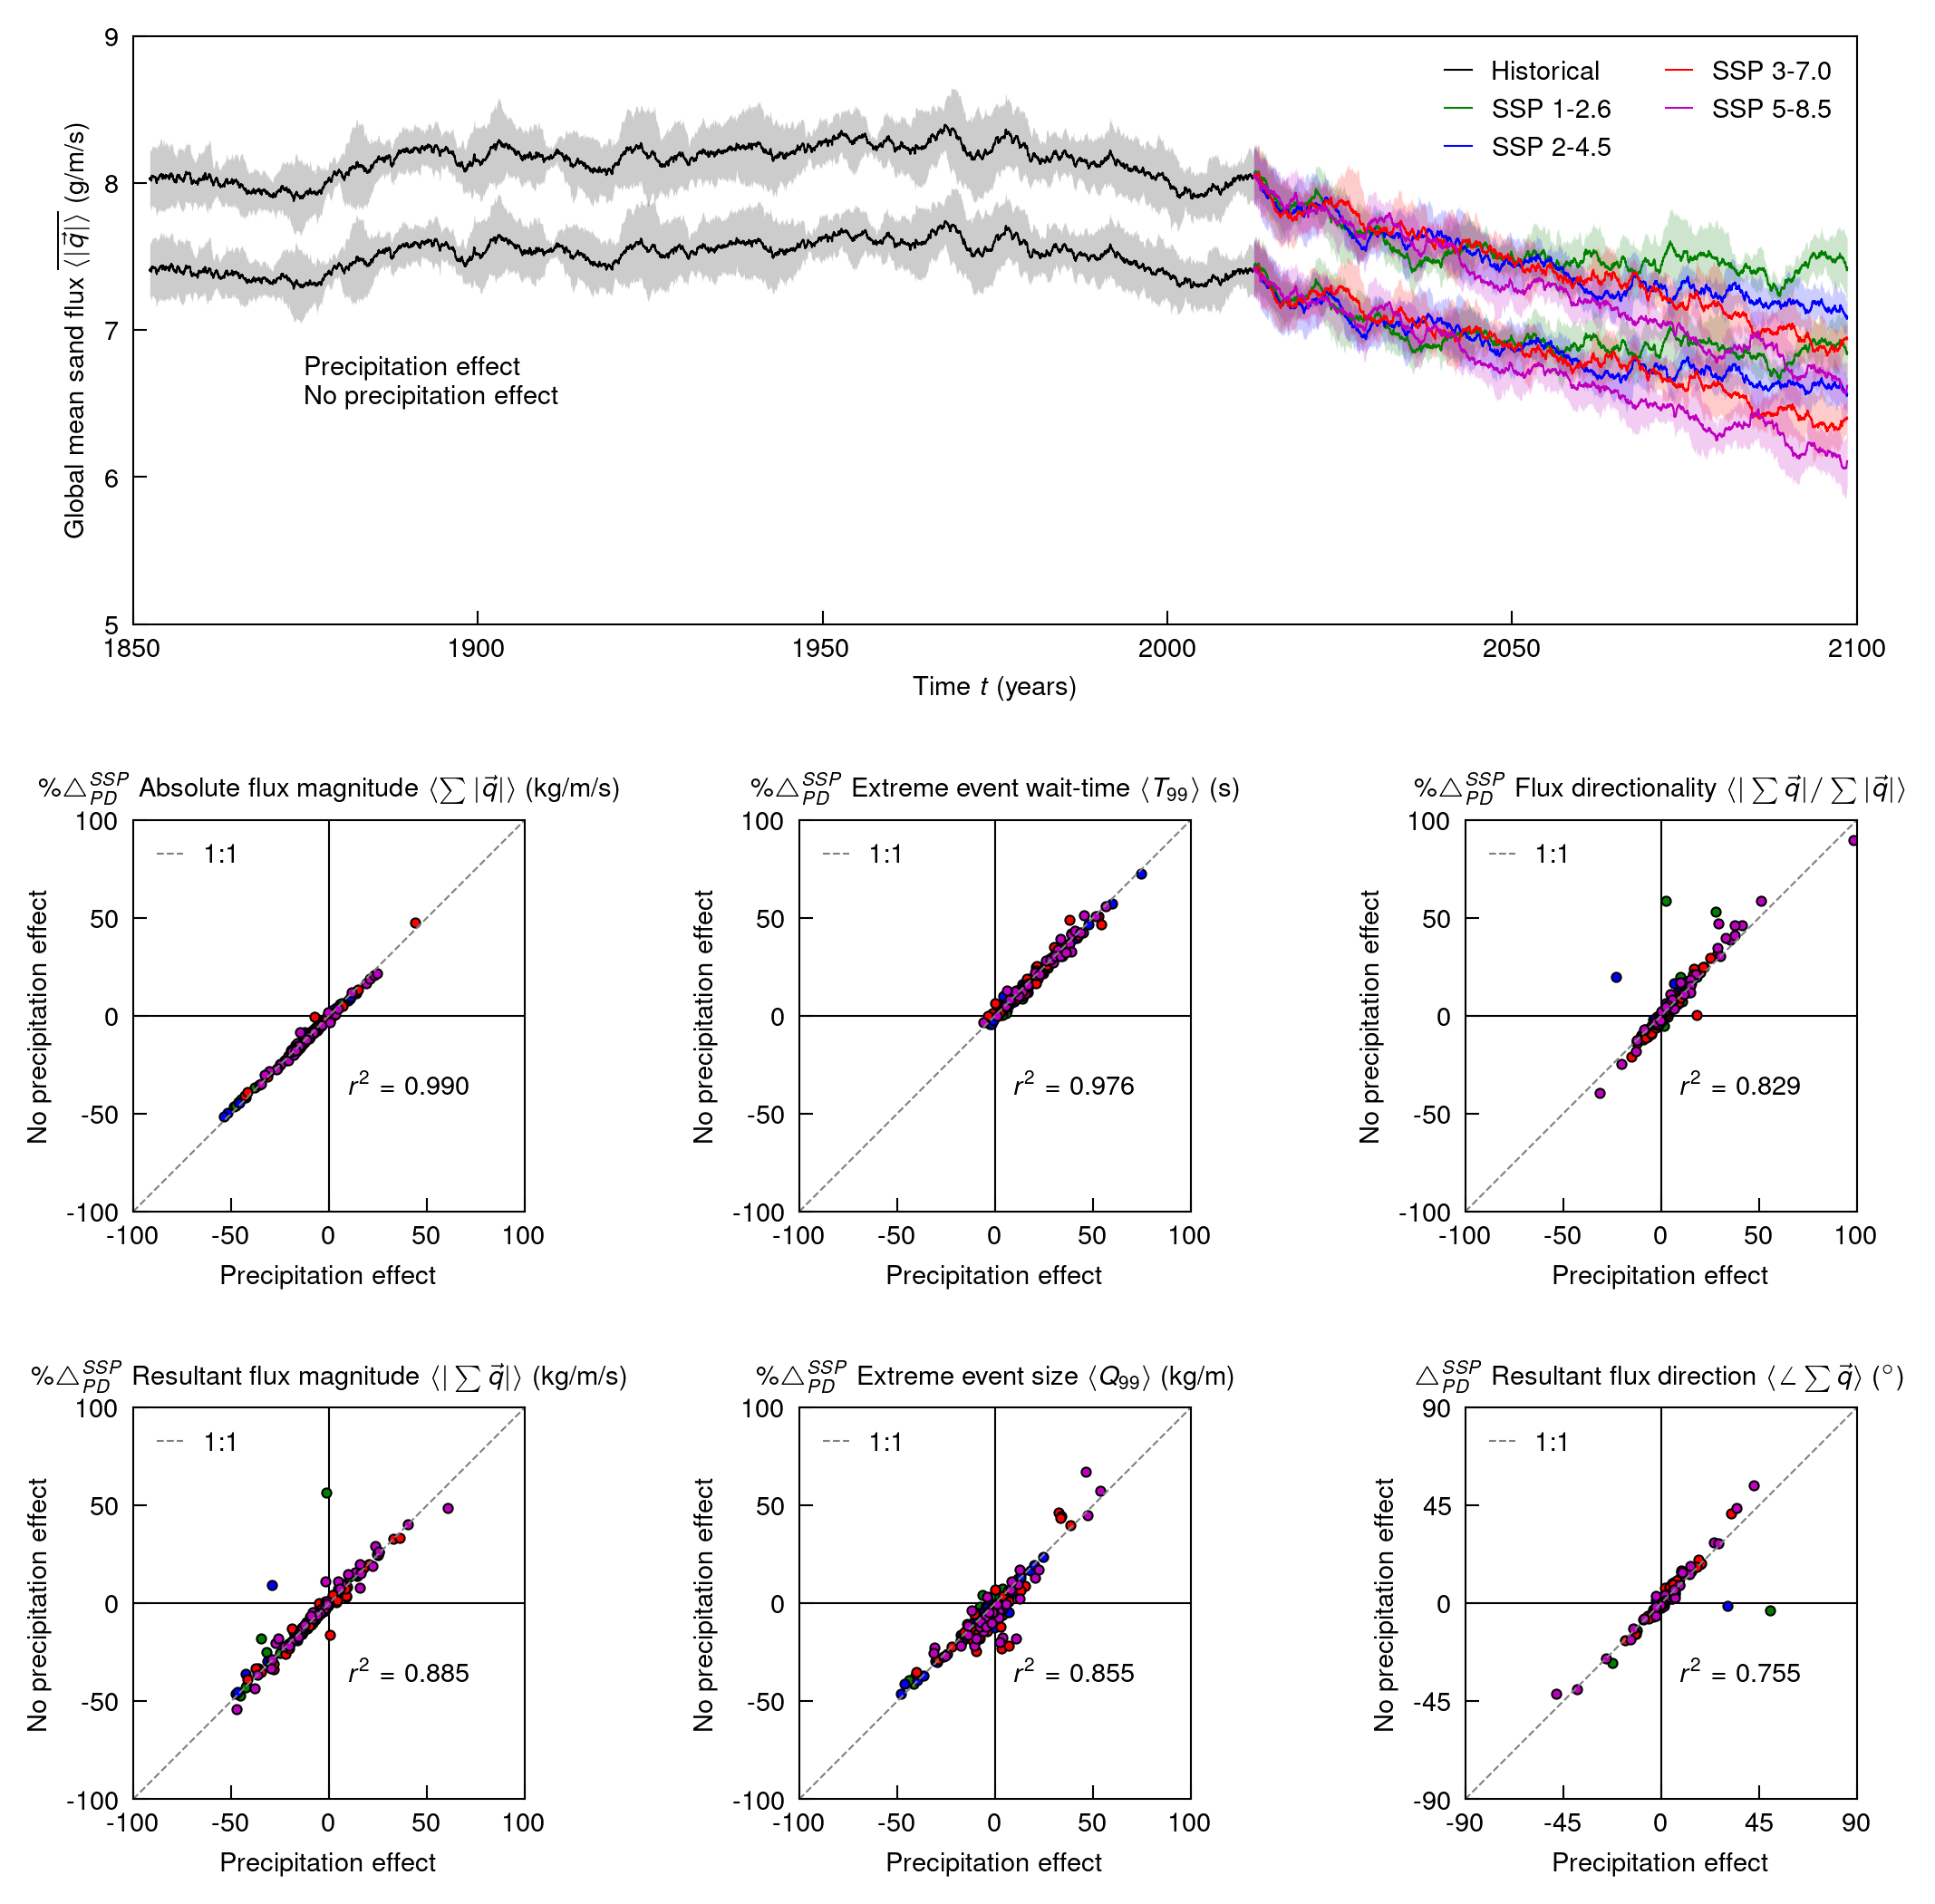

In [38]:
colors = ['k','g','b','r','m']
labels = ['Historical','SSP 1-2.6','SSP 2-4.5','SSP 3-7.0','SSP 5-8.5']
alpha = 0.2
h = 5

boty = 0.08
lefx = 0.08
bufy = 0.1
dely = 0.2
bufx = 0.14
delx = 0.2

fig = plt.gcf()

ax0 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*1,delx,dely])

temp0 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
temp1 = 100*(mean_summq_scenario_ends_dfmean_noprecip[1:]-mean_summq_scenario_ends_dfmean_noprecip[0])/mean_summq_scenario_ends_dfmean_noprecip[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-100,100],[-100,100],'--',c='grey',lw=lw,label='1:1')
plt.plot([100,-100],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[100,-100],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-100,100)
plt.ylim(-100,100)
ax0.set_xticks([-100,-50,0,50,100])
ax0.set_xticklabels(['-100','-50','0','50','100'])
ax0.set_yticks([-100,-50,0,50,100])
ax0.set_yticklabels(['-100','-50','0','50','100'])
plt.title('\%$\\triangle_{PD}^{SSP}$ Absolute flux magnitude $\\langle\\sum|\\vec{q}|\\rangle$ (kg/m/s)',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax1 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*1,delx,dely])

temp0 = 100*(qet_params_scenario_ends_dfmean[1:]-qet_params_scenario_ends_dfmean[0])/qet_params_scenario_ends_dfmean[0]
temp1 = 100*(qet_params_scenario_ends_dfmean_noprecip[1:]-qet_params_scenario_ends_dfmean_noprecip[0])/qet_params_scenario_ends_dfmean_noprecip[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-100,100],[-100,100],'--',c='grey',lw=lw,label='1:1')
plt.plot([100,-100],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[100,-100],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-100,100)
plt.ylim(-100,100)
ax1.set_xticks([-100,-50,0,50,100])
ax1.set_xticklabels(['-100','-50','0','50','100'])
ax1.set_yticks([-100,-50,0,50,100])
ax1.set_yticklabels(['-100','-50','0','50','100'])
plt.title('\%$\\triangle_{PD}^{SSP}$ Extreme event wait-time $\\langle T_{99}\\rangle$ (s)',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax2 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*0,delx,dely])

temp0 = 100*(qem_params_scenario_ends_dfmean[1:]-qem_params_scenario_ends_dfmean[0])/qem_params_scenario_ends_dfmean[0]
temp1 = 100*(qem_params_scenario_ends_dfmean_noprecip[1:]-qem_params_scenario_ends_dfmean_noprecip[0])/qem_params_scenario_ends_dfmean_noprecip[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-100,100],[-100,100],'--',c='grey',lw=lw,label='1:1')
plt.plot([100,-100],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[100,-100],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-100,100)
plt.ylim(-100,100)
ax2.set_xticks([-100,-50,0,50,100])
ax2.set_xticklabels(['-100','-50','0','50','100'])
ax2.set_yticks([-100,-50,0,50,100])
ax2.set_yticklabels(['-100','-50','0','50','100'])
plt.title('\%$\\triangle_{PD}^{SSP}$ Extreme event size $\\langle Q_{99}\\rangle$ (kg/m)',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax3 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*0,delx,dely])

temp0 = 100*(mean_msumqm_scenario_ends_dfmean[1:]-mean_msumqm_scenario_ends_dfmean[0])/mean_msumqm_scenario_ends_dfmean[0]
temp1 = 100*(mean_msumqm_scenario_ends_dfmean_noprecip[1:]-mean_msumqm_scenario_ends_dfmean_noprecip[0])/mean_msumqm_scenario_ends_dfmean_noprecip[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-100,100],[-100,100],'--',c='grey',lw=lw,label='1:1')
plt.plot([100,-100],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[100,-100],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-100,100)
plt.ylim(-100,100)
ax3.set_xticks([-100,-50,0,50,100])
ax3.set_xticklabels(['-100','-50','0','50','100'])
ax3.set_yticks([-100,-50,0,50,100])
ax3.set_yticklabels(['-100','-50','0','50','100'])
plt.title('\%$\\triangle_{PD}^{SSP}$ Resultant flux magnitude $\\langle|\\sum\\vec{q}|\\rangle$ (kg/m/s)',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax4 = fig.add_axes([lefx+(bufx+delx)*2,boty+(bufy+dely)*1,delx,dely])

temp0 = 100*(mean_fd_scenario_ends_dfmean[1:]-mean_fd_scenario_ends_dfmean[0])/mean_fd_scenario_ends_dfmean[0]
temp1 = 100*(mean_fd_scenario_ends_dfmean_noprecip[1:]-mean_fd_scenario_ends_dfmean_noprecip[0])/mean_fd_scenario_ends_dfmean_noprecip[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-100,100],[-100,100],'--',c='grey',lw=lw,label='1:1')
plt.plot([100,-100],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[100,-100],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-100,100)
plt.ylim(-100,100)
ax4.set_xticks([-100,-50,0,50,100])
ax4.set_xticklabels(['-100','-50','0','50','100'])
ax4.set_yticks([-100,-50,0,50,100])
ax4.set_yticklabels(['-100','-50','0','50','100'])
plt.title('\%$\\triangle_{PD}^{SSP}$ Flux directionality $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax5 = fig.add_axes([lefx+(bufx+delx)*2,boty+(bufy+dely)*0,delx,dely])

temp0 = (mean_msumqa_scenario_ends_dfmean[1:]-mean_msumqa_scenario_ends_dfmean[0])*180/np.pi
temp1 = (mean_msumqa_scenario_ends_dfmean_noprecip[1:]-mean_msumqa_scenario_ends_dfmean_noprecip[0])*180/np.pi
temp1[np.abs(temp1)>90] = temp0[np.abs(temp1)>90]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-90,90],[-90,90],'--',c='grey',lw=lw,label='1:1')
plt.plot([90,-90],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[90,-90],c='k',lw=lw,zorder=-1)
plt.text(10*0.9,-40*0.9,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.axis('square')
plt.xlim(-90,90)
plt.ylim(-90,90)
ax5.set_xticks([-90,-45,0,45,90])
ax5.set_xticklabels(['-90','-45','0','45','90'])
ax5.set_yticks([-90,-45,0,45,90])
ax5.set_yticklabels(['-90','-45','0','45','90'])
plt.title('$\\triangle_{PD}^{SSP}$ Resultant flux direction $\\langle\\angle\\sum\\vec{q}\\rangle$ ($^\\circ$)',fontsize=fs)
plt.xlabel('Precipitation effect')
plt.ylabel('No precipitation effect')

ax6 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*2,delx*3+bufx*2,dely*1.5])
for i in range(len(scenarios)):
    plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensmean_globmeans_scenarios_smoothed[i]*1e+3,lw=lw,color=colors[i],label=labels[i])
    plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ens_globstd_scenarios_smoothed[i])*1e+3,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ens_globstd_scenarios_smoothed[i])*1e+3,lw=0,alpha=alpha,color=colors[i],rasterized=True)
    plt.plot(ts_scenarios_smoothed_noprecip[i]*s2yr+1970,qm_ensmean_globmeans_scenarios_smoothed_noprecip[i]*1e+3,lw=lw,color=colors[i])
    plt.fill_between(ts_scenarios_smoothed_noprecip[i]*s2yr+1970,
                     (qm_ensmean_globmeans_scenarios_smoothed_noprecip[i]-qm_ens_globstd_scenarios_smoothed_noprecip[i])*1e+3,
                     (qm_ensmean_globmeans_scenarios_smoothed_noprecip[i]+qm_ens_globstd_scenarios_smoothed_noprecip[i])*1e+3,lw=0,alpha=alpha,color=colors[i],rasterized=True)
plt.text(1875,6.5,'Precipitation effect\nNo precipitation effect',fontsize=fs)        
plt.legend(frameon=False,handlelength=1,ncol=2)
plt.xlim(1850,2100)
plt.ylim(5,9)
plt.xlabel('Time $t$ (years)')
plt.ylabel('Global mean sand flux $\\overline{\\langle|\\vec{q}|\\rangle}$ (g/m/s)')
ax6.set_yticks([5,6,7,8,9])
ax6.set_yticklabels(['5','6','7','8','9'])

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw)  
ax6.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax6.spines[axis].set_linewidth(lw)
    
fig.set_size_inches(183/25.4,183/25.4, forward=True)
plt.savefig('figures/edfigI.pdf',dpi=600)
plt.savefig('figures/edfigI.png',dpi=600)

In [45]:
100*(np.mean(qm_ensmean_globmeans_scenarios_smoothed[0])-np.mean(qm_ensmean_globmeans_scenarios_smoothed_noprecip[0]))/np.mean(qm_ensmean_globmeans_scenarios_smoothed[0])

-8.511029750435736